# 1. Implementing your own Shazam
### Import libraries:

In [ ]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import csv
import pandas as pd
import ast 
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

### Utility functions from [AudioSignals.ipynb](https://github.com/lucamaiano/ADM/blob/master/2021/Homework_4/AudioSignals.ipynb):

In [ ]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

### Implemented functions:


In [ ]:
def shingling_matrix(dataframe, feature_index):
    '''Compute the shingling matrix and the list of values on which we buit the matrix of a given set of documents for a given feature.
        The the i-th value of a shingling vector for a given document can be 1 if the i-th word in the vocabulary is contained in the document, otherwise 0.

    Args:
        -  dataframe, a dataframe object containing all the documents and their features
        -  feature_idex, the index of the column on which we are working
    
    Return:
        - peaks_list, a list containing all the unique values for the  given feature (in our case all the unique values of thepeaks among all the documents)
        - Shigling, the shingling matrix  of our set of documents. The order of the matrix's rows is the same order of the list.'''

    n = dataframe.shape[0]    
    peaks_list = []

    for i in range(0,n):

        peaks_list = list(set(peaks_list)|set(dataframe.iloc[i,feature_index]))

    p = len(peaks_list)
    shingling = pd.DataFrame(np.zeros((p,n)),dtype=int)

    for i in tqdm(range(0,p)):

        for j in range(0,n):

            if peaks_list[i] in dataframe.iloc[j,feature_index]:
                shingling.iloc[i,j] = 1

    return peaks_list, shingling



def signature_matrix(shinglingmatrix,num_permutation):
    ''' Compute the signature matrix according to number of permutation of a shigling matrix of a set of documents.
        The signature of a document is the index of the first row in permuted shingling matrix in which the value is not 0.
        We will have for each documents n-signature where n is the number of permutations

    Args:
        -  Shiglingmatrix, a dataframe object whith shingling structure
        -  num_permutation, the number of permutation to applay to the shigling matrix in order to compute the signature one.
    
    Return:
        - Permuations, a matrix object in which each row is a permutation of the indexes of the shingling matrix.
        - Signature, the signature matrix  of our set of documents. The order of the matrix's rows is the same order of Permuations 
                     while the columns remain the same.'''

    permutations=[]
    n=shinglingmatrix.shape[1]
    signature = pd.DataFrame(np.zeros((num_permutation,n),dtype=int))
    for i in tqdm(range(0,num_permutation)):
        p = np.random.permutation(len(shinglingmatrix))
        permutations.append(p)
        s = shinglingmatrix.iloc[p]
        for j in range(0,n):
            index = np.where(np.array(s.iloc[:,j])==1)[0][0]
            signature.iloc[i,j] = int(index)
    
    return permutations, signature

def minhashing(signaturematrix, num_band):
    
    ''' Create the finger prints for each document according to the signature matrix of that set, where the legth of a fingerprint (row_for_band)
        is given by the number of rows of the matrix divided by num_band. num_band will also define the number of fingerprint for each document.
    
    Args:
        - signaturematix, a datframe object with signature's structure
        - num_ban, the length of the finger prints. 
    
    NB:
        The choice of num_band make us possible to change the threshold. 
        The TH is the minimun similarity that two documents must have in order to have at least one finger print equal.
        
        TH = (1/num_band)^(1/row_for_band)
       

    
    Return:
        - buckets, a dict object in which the keys are all the unique fingerprints generated by the process and the associeted value are a list containing
         all the documents with that fingerprint'''

    buckets = {}
    num_perm = signaturematrix.shape[0]
    num_doc = signaturematrix.shape[1]
    row_for_band = num_perm/num_band
    for i in range(0,num_band):
        for j in range(0,num_doc):
            key=tuple(signaturematrix.iloc[int(i*row_for_band):int(row_for_band+(i*row_for_band)),j])
            if key not in buckets.keys():
                buckets[key]=[j]
            else:
                buckets[key].append(j)
    return buckets


def compute_query(query_wav_directory, modelli_csv_directory, peaks_list, permutations_list, buckets):
    ''' Return the title (or titles) of the sogn which is more similar to the query.
        The passages to compute the query are the same we used to compute the documents
        

    Args:
        - query_wav_directory, the directory of the query.wav (NOTE: the parameters used to pass from .mp3 to .wav 
            must be the same used during the preprocessing of the documents)
        - modelli_csv_directory, the directory of our documents' dataframe.
        - peaks_list, a list contanining all the unique peaks in our set of documents
        - permutations_list, a matrix object with the permutations used to build our minhash
        - buckets, a dict object containing all the possible generated buckets according to the minhash

    
    Return:
        - The title (or a list of titles) of the document that is more similar to the query'''


    df = pd.read_table(modelli_csv_directory, sep=',', converters = {'Title':str,'Peaks':ast.literal_eval} )

    _, _, query_onset_env, query_peaks = load_audio_peaks(query_wav_directory, OFFSET, DURATION, HOP_SIZE)

     
    query_peaks = list(query_onset_env[query_peaks])
    query_peaks = np.array([round(x,1) for x in query_peaks])
    shingling_query = np.zeros(len(peaks_list),dtype=int)

    for i in range(len(peaks_list)):
        if peaks_list[i] in query_peaks:
            shingling_query[i] = 1
    
    num_perm = len(permutations_list)
    
    signature_query = np.zeros(num_perm,dtype=int)
    

    for i in range(num_perm):
        hash = permutations_list[i]
        index = np.where(shingling_query[hash]==1)[0][0]
        signature_query[i] = index
    

    num_row_for_band = len(list(buckets.keys())[0])
    num_band = int(num_perm/num_row_for_band)

    set_doc = set()



    for i in range(num_band):
        key = signature_query[int(i*num_row_for_band):int(num_row_for_band+(i*num_row_for_band))]
        try :
            set_doc.update(set(buckets[tuple(key)]))
        except KeyError:
            continue 
    
    set_doc = list(set_doc)

    if len(set_doc)==1:
        return  str(df.iloc[set_doc[0],0]).replace('_',' ')

    else :
        return np.array(df.iloc[set_doc,0],dtype= str)



    




### Global settings
Those are the parameters for the conversion from  file.mp:3 to file.wav and from file.wav to peak detection:

- *N_TRACKS*, number of tracks to read.
- *HOP_SIZE*.
- *OFFSET*, time (in seconds) before reading the file.
- *DURATION*, window of reading. 



In [ ]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 


### Preprocessing:  
we are converting our data from *file.mp3* to *file.wav*.

In [ ]:
data_folder = Path("/content/drive/MyDrive/ADM-HW04/MP3")
mp3_tracks = data_folder.glob("*/*/*.mp3")

In [ ]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

Now we create a file.csv containing all the informations needed for the implementation of the algorithm.

In [ ]:
tracks = data_folder.glob("*/*/*.wav")
data_csv_directory = "/content/drive/MyDrive/ADM-HW04/data.csv" 

In [ ]:
with open(data_csv_directory, "w", encoding='utf-8', newline='') as file:
  writer = csv.writer(file)
  
  header = ['Title','Peaks']

  writer.writerow(header)

  for idx, audio in tqdm(enumerate(tracks),total=N_TRACKS):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    title = str(audio).split('/')[-1]
    title = title[3:len(title)-4]
    peaks = list(onset_env[peaks])
    peaks = [round(x,1) for x in peaks]
    data = [title, peaks]
    print(data)
    writer.writerow(data)


In [ ]:
df = pd.read_table(data_csv_directory,sep=',',converters={'Title':str,'Peaks':ast.literal_eval})
df.head()

,Title,Peaks
0,Make_It,"[4.2, 3.6, 6.9, 5.0, 5.1, 7.9, 5.4, 4.3, 4.4, ..."
1,Somebody,"[14.0, 3.5, 4.3, 6.3, 10.9, 4.0, 13.4, 3.5, 5...."
2,Dream_On,"[3.2, 2.5, 3.7, 2.2, 3.9, 2.9, 4.1, 2.1, 3.8, ..."
3,One_Way_Street,"[4.9, 13.0, 3.4, 11.7, 6.9, 4.1, 2.1, 17.1, 12..."
4,Mama_Kin,"[6.9, 6.8, 4.5, 8.0, 3.0, 3.7, 2.6, 7.2, 8.2, ..."


### Passages of the algorithm: 
The  first passages consist  the building the structures of the algorithm in order to habe the possibility to compute the query.
First of all from the dataframe that we created before we take all the extracted peacks in order to create the signature matrix of our set of documents.

In [ ]:
peaks_list, shingling = shingling_matrix(df, 1)
peaks_list;

  0%|          | 0/304 [00:00<?, ?it/s]

Once we obtained our shingling matrix we need to choose a class of hash funtions from which we can take our b-random hash functions to detrmined the fingerprints of our documents.  

In our case the family from we choose our functions is the permutations of the signature matrix n-times and  each time for each document we take the index of the first row that has value different form  zero. This process should give us a new matrix with the same columns (one for each document) and number of rows equal to n.

In [ ]:
NUM_PERM = 60

In [ ]:
permutations, signature = signature_matrix(shingling,NUM_PERM)
permutations;

  0%|          | 0/60 [00:00<?, ?it/s]

The given matrix is named signature matrix from which we are taking our finger print.
In fact  we assign as finger print of $doc_i$, the first r-rows of the matrix on the column's document. We do this b-times such that $b*r=n$ so we will have b fingerprints for each document.  

It may happen that some documents could have the same fingerprint (among b), this is called collapse; this depends on the prameter n and b that we choose beacuse took random an hash function from my family the probability that the given hash fucntions would give the same results when applied to two different documents, it s equal  to the jacard similarity of the given documents. In our case each element of our fingerprint is an hash function.
In other word, similar documents have more chace to have the same finger print, in particular the minimum similarity (thrashold) that two documents have to have in order to have the same fingerprint is given by  $TH=(1/b)^{(1/r)}$. So depending on those parameters we will have different levels of accuracy  and  false positive rate.

This result is the keystone for the  computation of the query.

In [ ]:
NUM_BANDS = 4
NUM_OF_ROWS = 15
TH = (1/NUM_BANDS)**(1/NUM_OF_ROWS)
TH

0.9117224885582168

In [ ]:
buckets = minhashing(signature, NUM_BANDS)
buckets;

What we have done is storing  all the fingerprints as keys of a vocabulary and the associated documents as values of that key.  

Once we have all the structures of our algorithm we need only to compute the query. The first thing to do is to pre-process the query  in the same way we did with the documents; then once we obtain its peaks we have to build the shingling vector for the query and its corresponding signature vector according to the permutations that we used for the building.
Now with the same process descripted before we detrmine the finger prints of the query and search in our dictionary the values for thegiven keys (if the key exists). 
Now there are possibility:
- Any keys exist, so there are no similarity between the query and our documents (under the hipotesys that we did everything  correct).
- At least one key ping more than one document, false positive case. In order to resolve this we  can compute a more  sensible  similarity between the query and the given documents, than choose the best result.
- All the existing keys  ping the same document. We coputed the query!!! 

In [ ]:
for i in range(1,11):
        wav = '/content/drive/MyDrive/ADM-HW04/Query/track' + str(i) + '.wav' #directory of the query
        titolo = compute_query(query_wav_directory = wav, modelli_csv_directory = data_csv_directory, peaks_list = peaks_list, permutations_list = permutations , buckets = buckets)
        print('track' + str(i)+ ': '+str(titolo))

track1: Dream On
track2: I Want To Break Free
track3: October
track4: Ob-La-Di Ob-La-Da
track5: Karma Police
track6: Heartbreaker
track7: Go Your Own Way
track8: American Idiot
track9: Somebody
track10: Black Friday


# 2. Grouping songs together!
### Import libraries:

In [ ]:
import csv
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Utility functions from [AudioSignals.ipynb](https://github.com/lucamaiano/ADM/blob/master/2021/Homework_4/AudioSignals.ipynb):

In [61]:
def vectextract(trackid: int):
    """
    This function takes as input the track_id identifier and returns the corresponding
    row in the dataset  
    
    :param point:         the track_id of the dataset we are interested in 
    :retuns:              the row of the dataset we are interested in
    """
    point = point0[point0['track_id'] == trackid]
    point = np.array(point[[word for word in point.columns
                     if word != 'track_id' 
                           ]])
    return point

def distance(track1: int, centroid):
    """
    This function calculates the distance between a point and a centroid.
    
    :param track1:        track_id identifier of the point
    :param centroid:      row of coordinates of the centroid
    :retuns:              euclidean distance between the point and the centroid
    """
    point1 = vectextract(track1)
    point1 = np.transpose(point1)
    return np.sqrt(np.sum([(point1[i] - centroid[i]) ** 2 
                 for i in range(len(point1))]))

def naive_kmeans(k:int, points, eps):
    """
    Made-from-scartch version of KMeans
       
    :param k:             number of clusters
    :param point:         list of points, identified by the track_id value
    :param eps:           tolerance level to stop the algorithm
    :retuns:              list of sets of points. Each set is a cluster
    """
    # First I need to create the first centroids by random
    centroids = np.random.choice(len(points), k, replace=False)
    centroids = [vectextract(points[i]) for i in centroids]
    app = np.zeros((np.array(centroids).shape[0], np.array(centroids).shape[2]))
    for row in range(np.array(centroids).shape[0]):
        for col in range(np.array(centroids).shape[2]):
            app[row][col] = centroids[row][0][col]
    centroids = app
    while True:
        # Initializing a few more variables...
        centroids_update = centroids * 0
        c = [set() for i in range(k)]
        for x in points:
            # j is the index of the closest centroid to x
            j = np.argmin(np.array([distance(x, i) for i in centroids]))
            # so we add x to the cluster of centroid j
            c[j].add(x)
        for i in range(k):
            for pnt in c[i]:
                # The new centroid is the mean of all points in the cluster
                centroids_update[i] += np.transpose(vectextract(pnt)[0])
            if len(c[i]):
                centroids_update[i] /= len(c[i])
        # Here we check if the old and new centroids are close enough
        cond = cdist(centroids_update, centroids,'euclidean').all() <= eps
        if cond:  
            # print(centroids)
            val = 0
            for i in range(k):
                content = [np.transpose(vectextract(pnt)[0]) for pnt in c[i]]
                val += np.var(np.array(content))
            final = [c, np.var(centroids), val]
            return c
        centroids = centroids_update
        

def naive_kmeans2(k:int, points, eps):
    """
    Made-from-scartch version of KMeans
       
    :param k:             number of clusters
    :param point:         list of points, identified by the track_id value
    :param eps:           tolerance level to stop the algorithm
    :retuns:              variance between centroids and sum of variances inside clusters
    """
    # First I need to create the first centroids by random
    centroids = np.random.choice(len(points), k, replace=False)
    centroids = [vectextract(points[i]) for i in centroids]
    app = np.zeros((np.array(centroids).shape[0], np.array(centroids).shape[2]))
    for row in range(np.array(centroids).shape[0]):
        for col in range(np.array(centroids).shape[2]):
            app[row][col] = centroids[row][0][col]
    centroids = app
    iter_ = 0
    while True:
        iter_ += 1
        # Initializing a few more variables...
        centroids_update = centroids * 0
        c = [set() for i in range(k)]
        for x in points:
            # j is the index of the closest centroid to x
            j = np.argmin(np.array([distance(x, i) for i in centroids]))
            # so we add x to the cluster of centroid j
            c[j].add(x)
        for i in range(k):
            for pnt in c[i]:
                # The new centroid is the mean of all points in the cluster
                centroids_update[i] += np.transpose(vectextract(pnt)[0])
            if len(c[i]):
                centroids_update[i] /= len(c[i])
        # Here we check if the old and new centroids are close enough
        cond = cdist(centroids_update, centroids,'euclidean').all() <= eps or iter_>=35
        if cond:  
            # print(centroids)
            val = 0
            for i in range(k):
                content = [np.transpose(vectextract(pnt)[0]) for pnt in c[i]]
                val += np.var(np.array(content))
            return (np.var(centroids), val)
        centroids = centroids_update

In [48]:
def find_in_dic(dic, query):
    """
    Finds the key in a dictionary whose value (a set) contains the query
    
    :param dic:           the dictionary of sets
    :param query:         the value that we have 
    :retuns:              the key such that query in dic[key]
    """
    for key in dic:
        if query in dic[key]:
            return key
    return 'Error'
def find_in_list(lis, value):
    """
    Finds the index in a list whose value (a set) contains the query
    
    :param lis:           the list of sets
    :param value:         the value that we have 
    :retuns:              the index i such that query in lis[i]
    """
    for i in range(len(lis)):
        if value in lis[i]:
            return i

def find_in_list2(lis, value):
    """
    Finds the index in a list whose value is the query
    
    :param lis:           the list 
    :param value:         the value that we have 
    :retuns:              the index i such that query == lis[i]
    """
    for i in range(len(lis)):
        if value == lis[i]:
            return i

def getpossval(tag, ds):
    """
    Returns a list of 4 values to put in the pivot table. If the values we are considering
    are not numeric, it takes only the 4 most popular ones, otherwise it divides the values
    quantiles
    
    :param tag:           the column of the dataset we are considering
    :param ds:            the dataset
    :retuns:              the list of possible values we are considering
    """
    if tag in ['album_producer', 'track_language_code',
               'track_genre_top', 'artist_members']:
            poss_values = list(pd.unique(tracks[tag]))
            if len(poss_values) > 4 and tag != 'track_genre_top' and tag != 'track_language_code':
                poss_values = tracks[tag].value_counts().keys()[0:4]
            return poss_values
    lis = []
    for i in range(1,4):
        lis.append(ds[tag].quantile(.25*i))
    lis.append(ds[tag].max())
    return lis

def cat(value, tag, poss_values):
    """
    Puts each value in the right category: in particular if the value is numeric, it will
    put it in the right quantile.
    
    :param value:         the actual value
    :param tag:           the column of the dataset
    :param poss_values:   the list of all possible values which has the quantiles
    :retuns:              the category we are putting the value in
    """
    if tag in ['album_producer', 'track_language_code',
               'track_genre_top', 'artist_members']:
        return value
    for i in range(len(poss_values)):
        if value <= poss_values[i]:
            return [poss_values[i]]

In [55]:
def table(col, ds):
    
    # If the column is nuemric, I divide it into 4 categories
    if ds[col].dtypes == 'int64' or ds[col].dtypes == 'float64':
        ds[col] = pd.qcut(ds[col], q=4)
        
    # I create the table, normalized by columns
    table = pd.crosstab(ds[col], ds['Cluster'], normalize='columns') * 100
    
    # I add the column "Total" at the end of the table
    total = pd.Series(table.sum(axis=0).to_list(), name='Total')
    table = table.append(total).round(2)
    
    # I name the columns
    table.columns = [f'Cluster # {i}' for i in range (3)]
    
    return table

### 2.1 Getting your data
We read the three datasets.

In [2]:
echo = pd.read_csv('./echonest.csv')

In [3]:
features = pd.read_csv('./features.csv')

In [4]:
tracks = pd.read_csv('./tracks.csv')

**Echonest dataset**

In [5]:
echo.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 250 columns):
 #    Column                              Non-Null Count  Dtype  
---   ------                              --------------  -----  
 0    track_id                            13129 non-null  int64  
 1    audio_features_acousticness         13129 non-null  float64
 2    audio_features_danceability         13129 non-null  float64
 3    audio_features_energy               13129 non-null  float64
 4    audio_features_instrumentalness     13129 non-null  float64
 5    audio_features_liveness             13129 non-null  float64
 6    audio_features_speechiness          13129 non-null  float64
 7    audio_features_tempo                13129 non-null  float64
 8    audio_features_valence              13129 non-null  float64
 9    metadata_album_date                 2717 non-null   object 
 10   metadata_album_name                 2872 non-null   object 
 11   metadata_artist_latitude  

In [6]:
echo.shape

(13129, 250)

In [7]:
echo.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


In [9]:
features.shape

(106574, 519)

In [10]:
features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


**Tracks dataset**

In [11]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

In [12]:
tracks.shape

(106574, 53)

In [13]:
tracks.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


### Merge of the dataset

In [14]:
a = set(tracks.columns)
b = set(echo.columns)
c = set(features.columns)

In [15]:
print(a & b & c)

{'track_id'}


We see that the only column that the three datasets have in common is the "track_id" column. so we will use this column as the key to join the three datasets.

In [16]:
two_docs= tracks.merge(features, on='track_id')

In [17]:
total = two_docs.merge(echo, on='track_id')

In [18]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to temporal_features_223
dtypes: float64(764), int64(16), object(40)
memory usage: 82.2+ MB


In [19]:
total.shape

(13129, 820)

In [20]:
total.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


### Cleaning of the total dataset

I delete any duplicates.

In [21]:
total.drop_duplicates()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.676960,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.082770,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.926490,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.414010,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.267070,11.20267,26.454180,751.147705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-1.721207,4.686078,0.213789,0.208800,0.007911,0.06395,2.040730,1.97678,8.144532,147.040405
13125,124862,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-0.647897,1.282306,0.214586,0.181860,0.011247,0.06240,0.922360,0.85996,1.794739,6.321268
13126,124863,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-0.771613,1.623510,0.180471,0.128185,0.010103,0.06222,2.251160,2.18894,5.578341,89.180328
13127,124864,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-2.054143,7.927149,0.250178,0.219205,0.014851,0.06390,1.487440,1.42354,2.173092,12.503966


There are no duplicates because the number of lines has remained unchanged. I still have 13129 rows.

Now I replace missing numeric values with the mean and missing string values with a space.

In [22]:
for col in total.columns:
    if total[col].isnull().any() == True:
        if total[col].dtypes == 'object':
            total[col] = total[col].fillna("")
        else:
            val = total[col].mean()
            total[col] = total[col].fillna(val)

In [23]:
total.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


Finally I delete the symbols that are left in the columns containing strings, such as some html tags.

In [24]:
for col in total.columns:
    if total[col].dtypes == 'object':
        total[col] = total[col].str.replace(r'<[^<>]*>', '', regex=True)

In [25]:
total.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


### Choose your features (variable)

Now we need to reduce the size of our dataset. We want to use the PCA method.

Since we would like to apply PCA, first we should select all the numeric variables present in the dataset.

In [26]:
ds = total.select_dtypes([np.number])

But there are some numeric variables we don't want to be changed, like "album_id" and "artist_id". So for the moment we don't consider them. Once the reduction has been applied, we will reinsert the columns that will interest us.

In [27]:
ds = ds.drop(["album_id", "artist_id"], axis = 1)

In [28]:
print(ds.shape)
ds.head()

(13129, 778)


,track_id,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,4,47632,2,3,74,40.144635,-49.099826,192000,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


Before applying PCA we need to normalize the features. we do this using "preprocessing.StandardScaler" from the "sklearn" library. With this function we "standardize" the features by removing the mean and scaling to unit variance.

In [29]:
scaler = preprocessing.StandardScaler()

We standardize the whole dataset, but not the "track_id" column, because we don't want it to be changed.

In [30]:
temp_ds = pd.DataFrame(scaler.fit_transform(ds[ds.columns[1:]].values), columns = ds.columns[1:])

In [31]:
temp_ds.head()

,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,track_comments,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,-0.188685,0.038956,-0.372166,-0.209735,-0.029780,-0.767287,0.350908,0.352630,1.304715,0.965630
3,-0.293923,0.757754,0.503120,-0.860517,0.293227,0.823212,0.000000,1.567615e-16,-0.886405,-0.090184,...,-0.993299,0.536708,-0.182877,0.139612,-0.010956,1.124812,0.851688,0.849294,2.127603,1.527072
4,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,0.300454,-0.418382,-0.530095,-0.666811,-0.004175,-0.377522,1.426057,1.427025,2.924718,2.714005


Now we can apply PCA.

After some tests we noticed that to maintain at least 70% of the variance we need to have 75 components.

In [32]:
pca = PCA(n_components=75)
ds_pca = pca.fit_transform(temp_ds)

print(sum(pca.explained_variance_ratio_))

0.7165607481585103


In [33]:
final_temp_ds = pd.DataFrame(ds_pca, columns = ['Feature_%i' % i for i in range(75)])

In [34]:
print(final_temp_ds.shape)
final_temp_ds.head()

(13129, 75)


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74
0,3.072908,-2.797796,-5.727769,4.277086,3.146236,2.027724,6.745503,-0.946781,-2.278286,4.300846,...,-1.217839,-0.164497,-1.025975,-0.499616,0.637262,-1.302603,-1.245148,1.185309,-2.006199,-1.132094
1,5.773259,-5.391672,-5.296378,-1.594689,-3.638799,2.656065,-1.536727,5.895195,-0.186648,4.205522,...,-1.259859,0.455182,0.473178,0.062921,0.233204,-1.084560,1.199023,1.229745,2.274795,0.375253
2,2.650793,-4.148118,-4.570424,-0.058433,-2.859295,2.087842,-1.289189,-0.333308,-0.131072,1.773382,...,0.729523,-1.013840,0.411180,-0.552804,-0.080880,-0.911748,0.282866,0.531354,0.959501,-1.289933
3,9.136524,3.851304,-5.450469,0.690601,-1.309867,0.610318,-1.808065,4.077166,-0.603567,4.950122,...,0.634112,3.933348,2.108527,0.523638,-3.058469,0.410922,1.313081,2.948067,-1.468791,-0.463599
4,1.305628,-9.430696,-4.284233,0.703173,-3.847979,-1.252908,-2.945814,-2.202982,-0.536387,2.533939,...,-0.470366,-0.643088,0.138726,-1.120528,0.993993,-1.956316,0.382696,-0.230915,1.784201,-0.515211


Now let's add some variables of interest that may be useful later.

In [35]:
final_temp_ds = pd.concat([total['track_genre_top'], final_temp_ds], axis = 1)

In [36]:
final_temp_ds = pd.concat([total['track_duration'], final_temp_ds], axis = 1)

In [37]:
final_temp_ds = pd.concat([total['audio_features_tempo'], final_temp_ds], axis = 1)

In [38]:
final_temp_ds = pd.concat([total['track_language_code'], final_temp_ds], axis = 1)

In [39]:
final_temp_ds = pd.concat([total['metadata_artist_location'], final_temp_ds], axis = 1)

At the end we add the "track_id" column again and we get the final dataset.

In [40]:
final_ds = pd.concat([total['track_id'], final_temp_ds], axis = 1)

In [41]:
print(final_ds.shape)
final_ds.head()

(13129, 81)


,track_id,metadata_artist_location,track_language_code,audio_features_tempo,track_duration,track_genre_top,Feature_0,Feature_1,Feature_2,Feature_3,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74
0,2,"Georgia, US",en,165.922,168,Hip-Hop,3.072908,-2.797796,-5.727769,4.277086,...,-1.217839,-0.164497,-1.025975,-0.499616,0.637262,-1.302603,-1.245148,1.185309,-2.006199,-1.132094
1,3,"Georgia, US",en,126.957,237,Hip-Hop,5.773259,-5.391672,-5.296378,-1.594689,...,-1.259859,0.455182,0.473178,0.062921,0.233204,-1.084560,1.199023,1.229745,2.274795,0.375253
2,5,"Georgia, US",en,100.260,206,Hip-Hop,2.650793,-4.148118,-4.570424,-0.058433,...,0.729523,-1.013840,0.411180,-0.552804,-0.080880,-0.911748,0.282866,0.531354,0.959501,-1.289933
3,10,"Philadelphia, PA, US",en,111.562,161,Pop,9.136524,3.851304,-5.450469,0.690601,...,0.634112,3.933348,2.108527,0.523638,-3.058469,0.410922,1.313081,2.948067,-1.468791,-0.463599
4,134,"Georgia, US",en,114.290,207,Hip-Hop,1.305628,-9.430696,-4.284233,0.703173,...,-0.470366,-0.643088,0.138726,-1.120528,0.993993,-1.956316,0.382696,-0.230915,1.784201,-0.515211


We now need to implement the k-means algorithm. 

## Kmeans implementation

We are now going to implement the kmeans algorithm from scratch. First we need to do some preliminary code on our dataset, by standardizing each column (except track_id of course)

In [42]:
point0 = final_ds[[word for word in final_ds.columns
                     if word.startswith('Feature') 
                     or word == 'track_id'
                     or word == 'audio_features_tempo' 
                     or word == 'track_duration' 
                           ]]
scaler = StandardScaler()
scaler.fit(point0[[i for i in point0.columns if i != 'track_id']])
app = scaler.transform(point0[[i for i in point0.columns if i != 'track_id']])
X = pd.DataFrame(app)
point0 = pd.concat([point0['track_id'], X], axis = 1)

In [43]:
point0.describe()

,track_id,0,1,2,3,4,5,6,7,8,...,67,68,69,70,71,72,73,74,75,76
count,13129.000000,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,...,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,13129.000000,1.312900e+04,1.312900e+04
mean,34031.058268,4.264664e-16,-7.143853e-17,-1.082402e-17,-8.659215e-18,-2.597765e-17,8.659215e-18,-8.659215e-18,2.597765e-17,1.190642e-17,...,2.164804e-18,8.659215e-18,-1.785963e-17,4.329608e-18,2.164804e-18,1.136522e-17,-2.164804e-18,0.000000,7.576813e-18,8.659215e-18
std,28950.422182,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,...,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038,1.000038e+00,1.000038e+00
min,2.000000,-3.150959e+00,-1.114606e+00,-3.977082e+00,-3.364318e+00,-5.000122e+00,-2.774328e+00,-4.222549e+00,-5.044692e+00,-5.971230e+00,...,-1.073262e+01,-1.480466e+01,-9.306834e+00,-1.406526e+01,-9.898777e+00,-1.257312e+01,-1.104969e+01,-14.579071,-1.183476e+01,-1.144702e+01
25%,12986.000000,-7.743535e-01,-4.487766e-01,-6.264504e-01,-6.650043e-01,-6.298712e-01,-6.575926e-01,-6.388042e-01,-6.207736e-01,-6.138881e-01,...,-5.477718e-01,-4.862916e-01,-5.222917e-01,-5.587445e-01,-5.290779e-01,-5.489204e-01,-5.609869e-01,-0.544141,-5.725308e-01,-5.720854e-01
50%,28097.000000,-8.633912e-02,-1.689352e-01,5.366117e-02,2.590340e-02,6.522258e-03,-9.866033e-02,1.308670e-02,-1.215190e-02,-4.410946e-02,...,1.727745e-02,5.798458e-02,-1.679141e-02,-7.599828e-03,4.229371e-02,-1.036128e-03,1.040528e-02,-0.002817,2.180904e-03,1.511260e-02
75%,45021.000000,6.351192e-01,1.591547e-01,6.676037e-01,6.437601e-01,6.484252e-01,5.225248e-01,6.365534e-01,5.918627e-01,5.646072e-01,...,5.567726e-01,5.498258e-01,5.102039e-01,5.481246e-01,5.688267e-01,5.506530e-01,5.611596e-01,0.530627,5.864916e-01,6.037092e-01
max,124911.000000,3.655471e+00,1.343232e+01,5.900886e+00,8.051513e+00,9.850660e+00,2.015935e+01,1.662949e+01,1.446126e+01,7.058238e+00,...,2.231572e+01,2.285523e+01,1.840213e+01,2.408247e+01,1.399686e+01,2.208826e+01,1.279253e+01,21.398317,1.339941e+01,2.270120e+01


The implemented kmeans function starts by randomly generating centroids, and then comparing the new estimate with the old one. If the difference is smaller than a certain threshold, the function stops and returns the clusters in the form of a list of sets 

In [45]:
n_cluster_ = 6
naive_clusters = naive_kmeans(n_cluster_, np.array(point0['track_id']), 0.01)


In [46]:
kmeans = KMeans(n_clusters=n_cluster_, init='k-means++', random_state=0).fit(X)
clusters = [set() for i in range(n_cluster_)]
for x in point0['track_id']:
    j = np.argmin(np.array([distance(x, i) for i in kmeans.cluster_centers_]))
    clusters[j].add(x)
print([len(i) for i in clusters])

[226, 4330, 106, 610, 4366, 3491]


2
3
4
5
6
7


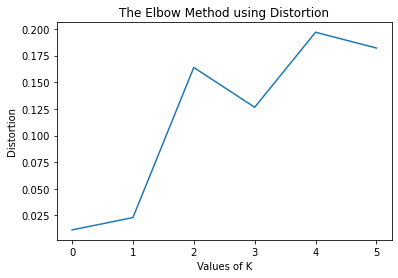

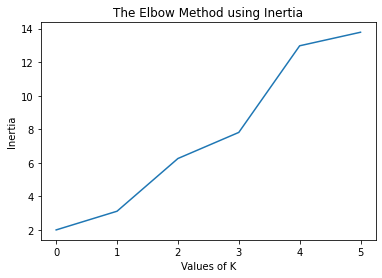

In [47]:
distortions = []
inertias = []

for i in range(2, 8):
    a, b = naive_kmeans2(i, np.array(point0['track_id']), 0.1)
    distortions.append(a)
    inertias.append(b)
    
plt.plot(distortions)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

plt.plot(inertias)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

The elbow method does not really indicate anything here, because the algorithm is too sensitive on initialization do draw conclusion over which number of clusters is best

In [49]:
tags = ['artist_longitude',
        'artist_latitude',
        'track_duration',
        'album_listens',
        'track_language_code', 'track_genre_top']
list_of_tables = []
for tag in tags:
    # Here we create a list of values we will display in our table
    poss_values = getpossval(tag, tracks)
    # Initializing a dictionary of sets, each set is for a value of the table and
    #      contains all the points that fall under that variable
    dic = {i: set() for i in poss_values}
    for trackid in final_ds['track_id']:
        # Finding the value of column tag for index track_id
        tracktag = list(tracks[tag][tracks['track_id'] == trackid])
        # Putting that value in the right category
        tracktag = cat(tracktag, tag, poss_values)
        try:
            dic[tracktag[0]].add(trackid)
        except Exception as e:
            pass
    # Initializing the pivot table
    table = np.zeros((n_cluster_, len(poss_values)))
    for i in np.array(final_ds['track_id']):
        # Finding where in the pivot table each point goes
        tag_ = find_in_dic(dic, i)
        b = find_in_list2(poss_values, tag_)
        a = find_in_list(naive_clusters, i)
        if a is None or b is None:
            continue
        table[a][b] += 1
    # Normalizing the pivot table
    for z in range(len(table)):
        if np.sum(table[z]) != 0:
            table[z] /= np.sum(table[z])
    table = np.transpose(table)
    table = pd.DataFrame(table)  
    table.index = poss_values
    table = table[(table.T != 0).any()]
    list_of_tables.append(table)

In the continuous variables I have decided to break the variables into four categories by looking at quantiles. In other words I picked different intervals so that the prior probability of for a song to be in a specific category is 0.25. This way it is even easier to understand and appreciate the effect of clustering, as a higher or lower value in the table is entirely an effect of clusterization (and not of some ill-picked categorization)

In [50]:
print(tags[0])

list_of_tables[0].index = ['-180 : -79.99', '-79.98 : -73.55', '-73.54 : 4.35', '4.36+']
list_of_tables[0]

artist_longitude


,0,1,2,3,4,5
-180 : -79.99,0.333935,0.283458,0.316002,0.367347,0.222727,0.183908
-79.98 : -73.55,0.287906,0.219451,0.288743,0.183673,0.190909,0.183908
-73.54 : 4.35,0.201264,0.245636,0.189046,0.163265,0.325000,0.149425
4.36+,0.176895,0.251455,0.206209,0.285714,0.261364,0.482759


In this table we can observe that latitude -180 : -79.99 is dominant in cluster 0, 1, 2, and 3 while in cluster 4 latitude -73.54 : 4.35 is predominant and in cluster 5 latitude 4.36+ is where most values are

In [51]:
print(tags[1])
list_of_tables[1].index = ['-90 : 39.27', '39.28 : 41.38', '41.39 : 48.85', '48.86+']
list_of_tables[1]

artist_latitude


,0,1,2,3,4,5
-90 : 39.27,0.326715,0.273067,0.278900,0.244898,0.179545,0.149425
39.28 : 41.38,0.277978,0.229426,0.300858,0.244898,0.220455,0.126437
41.39 : 48.85,0.206679,0.251455,0.242807,0.183673,0.281818,0.367816
48.86+,0.188628,0.246052,0.177436,0.326531,0.318182,0.356322


In this table we can see that in cluster 0 we have that most tracks have latitude -90 : 39.27, in cluster 1 we have that most songs have latitude  48.86+, in cluster 2 we have that most songs have latitude 39.28 : 41.38, in clister 3 most songs have latitude 48.86+, in cluster 4 and 5most songs have latitude 41.39 : 48.85

In [52]:
print(tags[2])
list_of_tables[2].index = ['0 : 149', '150 : 216', '217 : 305', '306+']
list_of_tables[2]

track_duration


,0,1,2,3,4,5
0 : 149,0.206897,0.041124,0.323723,0.426966,0.340938,0.474074
150 : 216,0.350272,0.152264,0.349753,0.292135,0.299113,0.274074
217 : 305,0.307169,0.331078,0.265568,0.191011,0.248416,0.133333
306+,0.135662,0.475534,0.060956,0.089888,0.111534,0.118519


We can see that tracks in cluster 0 and 2 have a duration which is most likely in 150 : 216, in cluster 1 they usually have duration greater than 306, in cluster 3, 4 and 5 they have duration below 149

In [53]:
print(tags[3])
list_of_tables[3].index = ['0 : 3361', '3362 : 8982', '8983 : 23635', '23636+']
list_of_tables[3]

album_listens


,0,1,2,3,4,5
0 : 3361,0.194646,0.309214,0.326524,0.202247,0.250951,0.200000
3362 : 8982,0.270417,0.270953,0.300988,0.202247,0.247148,0.251852
8983 : 23635,0.292650,0.242061,0.234596,0.235955,0.290241,0.133333
23636+,0.242287,0.177772,0.137891,0.359551,0.211660,0.414815


In cluster 0 the mode of number of listens is in 8983 : 23635, in cluster 1 and 2 it is below 3361, in cluster 3 and 5 it is over 23636, in cluster 4 it is 8983 : 23635

In [54]:
print(tags[4])
list_of_tables[4]

track_language_code


,0,1,2,3,4,5
en,0.960883,0.966932,0.950901,1.0,0.966667,1.0
es,0.011033,0.014085,0.025786,0.0,0.020000,0.0
fi,0.000000,0.000612,0.000353,0.0,0.003333,0.0
pt,0.015045,0.003062,0.002119,0.0,0.000000,0.0
tr,0.003009,0.004287,0.003886,0.0,0.000000,0.0
sw,0.000000,0.000000,0.001766,0.0,0.000000,0.0
el,0.001003,0.000612,0.001060,0.0,0.000000,0.0
ar,0.001003,0.002449,0.000000,0.0,0.000000,0.0
fr,0.005015,0.001225,0.004239,0.0,0.006667,0.0
ja,0.000000,0.000612,0.000706,0.0,0.000000,0.0


In this table we see the effect of having a very strong prior probability of being in English: in each cluster the language that is most likely to happen is English, while any other language is negligible

In [55]:
print(tags[5])
list_of_tables[5]

track_genre_top


,0,1,2,3,4,5
Hip-Hop,0.057308,0.039615,0.157670,0.072727,0.017657,0.025641
Pop,0.041854,0.034231,0.041386,0.018182,0.011236,0.000000
Rock,0.316162,0.302692,0.555106,0.200000,0.203852,0.102564
Experimental,0.001932,0.000385,0.002699,0.000000,0.001605,0.000000
Folk,0.169994,0.121154,0.059829,0.127273,0.004815,0.243590
Jazz,0.019317,0.051923,0.015969,0.000000,0.006421,0.012821
Electronic,0.108822,0.370385,0.120108,0.454545,0.731942,0.294872
International,0.010947,0.011154,0.017319,0.000000,0.012841,0.025641
Blues,0.005795,0.008846,0.007197,0.000000,0.003210,0.000000
Classical,0.057308,0.042692,0.008097,0.109091,0.001605,0.282051


Since we can interpret each column of the table as a vector of probabilities, we have that conditioned on being in a certain cluster, a song is most likely respectively Folk, Electronic, Rock, Electronic, Electronic, and Classical. 

### 2.4.7 K-Means++ Analysis

Now we do our analysis using only the following two datasets: `features.csv` and `tracks.csv`.

In [2]:
features = pd.read_csv('./features.csv')

In [3]:
tracks = pd.read_csv('./tracks.csv')

### Merge two dataset

Now let's merge the two documents. as before, we use `track_id` as the key to join them.

In [4]:
two_data = tracks.merge(features, on='track_id')

In [5]:
two_data.shape

(106574, 571)

In [6]:
two_data.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


### Cleaning of the total dataset

First of all we check if there are any duplicates.

In [7]:
two_data.drop_duplicates()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
106571,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
106572,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


There are no duplicates because the number of rows remains unchanged.

Now I replace missing numeric values with the mean and missing string values with a space.

In [8]:
for col in two_data.columns:
    if two_data[col].isnull().any() == True:
        if two_data[col].dtypes == 'object':
            two_data[col] = two_data[col].fillna("")
        else:
            val = two_data[col].mean()
            two_data[col] = two_data[col].fillna(val)

In [9]:
two_data.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


Finally I delete the symbols that are left in the columns containing strings, such as some html tags.

In [10]:
for col in two_data.columns:
    if two_data[col].dtypes == 'object':
        two_data[col] = two_data[col].str.replace(r'<[^<>]*>', '', regex=True)

In [11]:
for col in two_data.columns:
    if two_data[col].dtypes == 'object':
        two_data[col] = two_data[col].replace("\n", "")
        two_data[col] = two_data[col].replace("\t", "")

In [12]:
two_data.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,4,"""spiritual songs"" from Nicky Cook",2710,,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


### Dimensionality reduction

As before, we want to use the PCA method to reduce the size of our dataset.

In [13]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

We select again all the numeric variables.

In [14]:
ds2 = two_data.select_dtypes([np.number])

But there are some numeric variables we don't want to be changed. So for the moment we don't consider them. Once the reduction has been applied, we will reinsert the columns that will interest us.

In [15]:
ds2 = ds2.drop(["album_id", "artist_id", "track_duration", "album_comments", "album_listens", "album_tracks"], axis = 1)

In [16]:
print(ds2.shape)
ds2.head()

(106574, 530)


,track_id,album_favorites,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_favorites,track_interest,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,4,0,9,40.058324,-74.405661,256000,0,2,4656,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,4,0,9,40.058324,-74.405661,256000,0,1,1470,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,4,0,9,40.058324,-74.405661,256000,0,6,1933,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,4,3,74,39.901626,-38.668642,192000,0,178,54881,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,2,2,10,51.895927,0.891874,256000,0,0,978,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


Before applying PCA we need to normalize the features. we do this using "preprocessing.StandardScaler" from the "sklearn" library. With this function we "standardize" the features by removing the mean and scaling to unit variance.

In [17]:
scaler = preprocessing.StandardScaler()

As before, we standardize the whole dataset, but not the `track_id` column, because we don't want it to be changed.

In [18]:
temp_ds2 = pd.DataFrame(scaler.fit_transform(ds2[ds2.columns[1:]].values), columns = ds2.columns[1:])

In [19]:
temp_ds2.head()

,album_favorites,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_favorites,track_interest,track_listens,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.865961,-0.300859,-0.209350,1.328778e-02,-8.473421e-01,-0.107577,-0.098205,-0.087505,0.058614,-0.129092,...,-1.200560,-1.537657,-1.595043,-0.266432,0.425841,1.007362,0.874131,-0.454603,-0.369213,0.775698
1,0.865961,-0.300859,-0.209350,1.328778e-02,-8.473421e-01,-0.107577,-0.098205,-0.161504,-0.108917,-0.226127,...,-0.938948,-1.210805,-0.675913,-0.299409,0.463112,0.975158,0.643107,-0.454603,-0.491744,1.064853
2,0.865961,-0.300859,-0.209350,1.328778e-02,-8.473421e-01,-0.107577,-0.098205,0.208490,-0.084571,-0.146780,...,-1.561604,-1.461126,-1.162622,-0.254636,-0.034719,0.011006,-0.065367,-0.454603,-0.335249,0.167182
3,0.865961,0.175510,0.437346,6.447103e-14,-2.358624e-15,-1.053999,-0.098205,12.936260,2.699625,5.954839,...,-0.655213,-0.595296,-1.299392,-0.090255,0.385908,0.758699,0.889532,-0.454603,0.107731,0.018234
4,0.227599,0.016720,-0.199400,1.017104e+00,9.379990e-01,-0.107577,-0.098205,-0.235502,-0.134788,-0.245185,...,-0.098756,0.151932,-0.085646,-0.143811,0.481748,-0.169453,-0.111572,-0.265064,-0.008018,-0.341557


Now we can apply PCA.

We can pass how much variance we want PCA to capture. If we pass 0.71 as a parameter to the PCA model, it means that PCA will hold 71% of the variance and the number of components required to capture 71% variance will be used.

In [20]:
pca = PCA(0.71)

In [21]:
ds_pca = pca.fit_transform(temp_ds2)

Therefore the number of components needed to maintain 71% of the variance is the following:

In [22]:
pca.n_components_

54

In fact, we can see that the total variance retained is, more or less, the one we have passed as a parameter:

In [23]:
print(sum(pca.explained_variance_ratio_))

0.7102406122937427


Now let's convert the PCA result into a dataframe and name the columns.

In [24]:
final_temp_ds2 = pd.DataFrame(ds_pca, columns = ['Feature_%i' % i for i in range(54)])

In [25]:
print(final_temp_ds2.shape)
final_temp_ds2.head()

(106574, 54)


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53
0,2.071006,-3.075296,-5.556977,0.068496,2.255373,-3.618791,-5.028607,-0.916878,-5.097625,-4.085829,...,-1.774458,-1.183364,-0.149342,-0.704221,1.733779,0.350332,0.850438,0.562608,0.312432,-2.150291
1,3.522058,-5.365361,-4.317184,-1.124669,-3.044923,2.251967,-0.227389,4.718958,-0.600873,-3.425511,...,-0.646504,-0.033542,0.728803,-0.514138,2.182189,-1.316554,-0.377167,0.409909,-0.852269,-0.189478
2,0.963621,-3.160727,-3.482567,-0.944500,-1.101613,0.475784,-2.376769,1.254699,0.989708,-1.740110,...,-0.434548,-0.996258,0.101106,-1.295546,2.027610,-0.401895,1.917310,0.060698,-0.520811,-3.021218
3,6.500540,1.484680,-4.812206,-0.986068,-2.015332,0.139932,0.220120,3.853658,0.328750,-2.976393,...,-0.364702,-1.020500,-0.516472,-0.914984,-0.805675,0.090384,0.037177,-0.721729,-1.901766,-0.981322
4,0.863905,-1.135431,2.975712,-0.822828,-2.384612,4.566369,-0.169936,-1.829952,1.030909,-2.027141,...,-0.871433,0.134657,-0.639161,-0.659302,-0.709447,-0.077393,1.023658,-0.191043,0.288428,-0.172413


### Clustering with K-Means++

In [26]:
from sklearn.cluster import KMeans

Before applying K_Means++ we need to find the optimal number of clusters. Then we build two graphs by computing K-Means++ with a number of clusters in a range (1,10). Then from the graphs we will try to understand what is the optimal number of clusters.

In the following algorithm we compute these variables:
* **Distortion:** It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
* **Inertia:** It is the sum of squared distances of samples to their closest cluster center.

We calculate the "distortion" and "inertia" for each value of k (that is, the naumber of clusters) in the given range, (1,10).

In [27]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(final_temp_ds2)
 
    distortions.append(sum(np.min(cdist(final_temp_ds2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / final_temp_ds2.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(final_temp_ds2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / final_temp_ds2.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [28]:
import matplotlib.pyplot as plt

Now we plot the two graphs and we see which is the optimal number of clusters.

This is the graph using "distortion".

1 : 17.087214663408723
2 : 16.089516216204448
3 : 15.59864242807944
4 : 15.583425554084876
5 : 15.331317527884124
6 : 15.159184249718207
7 : 14.984767366403778
8 : 14.831271311920867
9 : 14.822683178228427


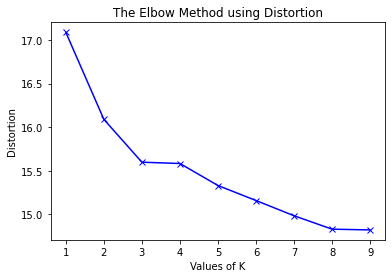

In [29]:
for key, val in mapping1.items():
    print(f'{key} : {val}')
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In this case we see that the optimal number of clusters is 3. But for confirmation we use the `KneeLocator` function from the `kneed` library which helps us to understand which is the optimal number of clusters.

In [30]:
from kneed import KneeLocator

In [31]:
kl = KneeLocator(range(1, 10), distortions, curve="convex", direction="decreasing")

In [32]:
kl.elbow

3

This is the graph using "inertia".

1 : 40041693.81472001
2 : 36073857.411396205
3 : 34223433.22476629
4 : 32888897.03942386
5 : 31872145.021192145
6 : 31060040.928461198
7 : 30432902.161847144
8 : 29922575.228965633
9 : 29119271.944307573


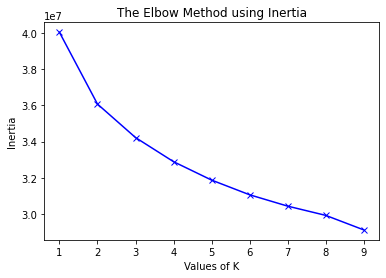

In [33]:
for key, val in mapping2.items():
    print(f'{key} : {val}')
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


In this case it is not very clear from the graph which is the optimal number of clusters. Therefore, as in the previous case, we use the `KneeLocator` function to better understand which is the optimal number to choose.

In [34]:
kl = KneeLocator(range(1, 10), inertias, curve="convex", direction="decreasing")

In [35]:
kl.elbow

3

Now we can apply K-Means++. Since in both cases we have obtained 3 as the optimal number of clusters, 3 will be the number of clusters we will use.

In [36]:
our_model = KMeans(n_clusters=3)

In [37]:
our_model.fit(final_temp_ds2)

KMeans(n_clusters=3)

In [38]:
cluster = our_model.predict(final_temp_ds2)

Now let's add the column where each row indicates each song which cluster it belongs to.

In [39]:
final_temp_ds2['Cluster'] = 0
final_temp_ds2['Cluster'] = cluster

In [40]:
final_temp_ds2.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Cluster
0,2.071006,-3.075296,-5.556977,0.068496,2.255373,-3.618791,-5.028607,-0.916878,-5.097625,-4.085829,...,-1.183364,-0.149342,-0.704221,1.733779,0.350332,0.850438,0.562608,0.312432,-2.150291,2
1,3.522058,-5.365361,-4.317184,-1.124669,-3.044923,2.251967,-0.227389,4.718958,-0.600873,-3.425511,...,-0.033542,0.728803,-0.514138,2.182189,-1.316554,-0.377167,0.409909,-0.852269,-0.189478,2
2,0.963621,-3.160727,-3.482567,-0.944500,-1.101613,0.475784,-2.376769,1.254699,0.989708,-1.740110,...,-0.996258,0.101106,-1.295546,2.027610,-0.401895,1.917310,0.060698,-0.520811,-3.021218,2
3,6.500540,1.484680,-4.812206,-0.986068,-2.015332,0.139932,0.220120,3.853658,0.328750,-2.976393,...,-1.020500,-0.516472,-0.914984,-0.805675,0.090384,0.037177,-0.721729,-1.901766,-0.981322,0
4,0.863905,-1.135431,2.975712,-0.822828,-2.384612,4.566369,-0.169936,-1.829952,1.030909,-2.027141,...,0.134657,-0.639161,-0.659302,-0.709447,-0.077393,1.023658,-0.191043,0.288428,-0.172413,2


Now we can add again some columns that will be useful to us in our analysis.

In [41]:
final_ds2 = pd.concat([two_data['track_genre_top'], final_temp_ds2], axis = 1)

In [42]:
final_ds2 = pd.concat([two_data['track_duration'], final_ds2], axis = 1)

In [43]:
final_ds2 = pd.concat([two_data['track_language_code'], final_ds2], axis = 1)

In [44]:
final_ds2 = pd.concat([two_data['artist_location'], final_ds2], axis = 1)

In [45]:
final_ds2 = pd.concat([two_data['album_tracks'], final_ds2], axis = 1)

In [46]:
final_ds2 = pd.concat([two_data['album_type'], final_ds2], axis = 1)

In [47]:
final_ds2 = pd.concat([two_data['album_listens'], final_ds2], axis = 1)

In [48]:
final_ds2 = pd.concat([two_data['album_comments'], final_ds2], axis = 1)

In [49]:
final_ds2 = pd.concat([two_data['artist_id'], final_ds2], axis = 1)

In [50]:
final_ds2 = pd.concat([two_data['album_id'], final_ds2], axis = 1)

In [51]:
final_ds2 = pd.concat([two_data['track_id'], final_ds2], axis = 1)

This is our final dataset.

In [52]:
print(final_ds2.shape)
final_ds2.head()

(106574, 66)


,track_id,album_id,artist_id,album_comments,album_listens,album_type,album_tracks,artist_location,track_language_code,track_duration,...,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Cluster
0,2,1,1,0,6073,Album,7,New Jersey,en,168,...,-1.183364,-0.149342,-0.704221,1.733779,0.350332,0.850438,0.562608,0.312432,-2.150291,2
1,3,1,1,0,6073,Album,7,New Jersey,en,237,...,-0.033542,0.728803,-0.514138,2.182189,-1.316554,-0.377167,0.409909,-0.852269,-0.189478,2
2,5,1,1,0,6073,Album,7,New Jersey,en,206,...,-0.996258,0.101106,-1.295546,2.027610,-0.401895,1.917310,0.060698,-0.520811,-3.021218,2
3,10,6,6,0,47632,Album,2,,en,161,...,-1.020500,-0.516472,-0.914984,-0.805675,0.090384,0.037177,-0.721729,-1.901766,-0.981322,0
4,20,4,4,0,2710,Album,13,Colchester England,en,311,...,0.134657,-0.639161,-0.659302,-0.709447,-0.077393,1.023658,-0.191043,0.288428,-0.172413,2


### Characterize your clusters

Now we build a function that will be useful to us to build our pivot tables.

##### 1 - Track duration

In [56]:
table('track_duration', final_ds2)

,Cluster # 0,Cluster # 1,Cluster # 2
track_duration,,,
"(-0.001, 149.0]",36.62,26.12,15.89
"(149.0, 216.0]",25.73,24.57,24.74
"(216.0, 305.0]",19.54,23.16,30.23
"(305.0, 18350.0]",18.11,26.14,29.14
Total,100.00,100.00,100.00


We can see that most of the elements in "Cluster # 0" are in the first range, while most of the elements in "Cluster # 1" are in the fourth range. As regards the elements of "Cluster # 2", on the other hand, we see that most of them are in the third interval.

##### 2 - Track language

In [57]:
table('track_language_code', final_ds2)

,Cluster # 0,Cluster # 1,Cluster # 2
track_language_code,,,
,84.70,85.77,86.87
ar,0.00,0.03,0.00
az,0.00,0.00,0.00
bg,0.00,0.02,0.00
bm,0.00,0.00,0.00
cs,0.01,0.00,0.00
de,0.01,0.16,0.03
ee,0.02,0.00,0.00
el,0.01,0.01,0.00


In this case we can see that most of the elements of all clusters are in English.

##### 3 - Album tracks

In [58]:
table('album_tracks', final_ds2)

,Cluster # 0,Cluster # 1,Cluster # 2
album_tracks,,,
"(-1.001, 7.0]",28.25,30.40,30.21
"(7.0, 11.0]",25.45,23.49,23.32
"(11.0, 17.0]",20.61,21.04,22.73
"(17.0, 652.0]",25.69,25.07,23.74
Total,100.00,100.00,100.00


In this case we can see that most of the elements of all clusters are in the first range.

##### 4 - Album type

In [59]:
table('album_type', final_ds2)

,Cluster # 0,Cluster # 1,Cluster # 2
album_type,,,
,5.03,7.92,5.57
Album,78.13,80.05,86.58
Contest,0.01,0.02,0.01
Live Performance,6.83,4.99,3.01
Radio Program,9.03,6.14,4.07
Single Tracks,0.96,0.88,0.77
Total,100.00,100.00,100.00


Most of the elements of all clusters are albums.

##### 5 - Album listens

In [60]:
table('album_listens', final_ds2)

,Cluster # 0,Cluster # 1,Cluster # 2
album_listens,,,
"(-1.001, 3361.0]",29.61,22.22,23.71
"(3361.0, 8982.0]",28.33,22.49,24.43
"(8982.0, 23635.0]",23.02,24.42,26.85
"(23635.0, 3564243.0]",19.04,30.87,25.02
Total,100.00,100.00,100.00


We can see that most of the elements in "Cluster # 0" are in the first range, while most of the elements in "Cluster # 1" are in the fourth range. As regards the elements of "Cluster # 2", on the other hand, we see that most of them are in the third interval.

##### 6 - Track genre

In [61]:
table('track_genre_top', final_ds2)

,Cluster # 0,Cluster # 1,Cluster # 2
track_genre_top,,,
,46.26,60.17,53.78
Blues,0.03,0.19,0.09
Classical,0.09,3.66,0.10
Country,0.17,0.20,0.18
Easy Listening,0.00,0.03,0.04
Electronic,6.34,3.96,14.09
Experimental,11.89,9.61,8.81
Folk,1.04,6.28,1.12
Hip-Hop,1.86,0.44,6.51


We can see that most of the elements in "Cluster # 0" and in "Cluster # 1" are "Experimental", while most of the elements in "Cluster # 2" are "Electronic".

In our opinion, perhaps it is better to have fewer observations with more features because, even if the observations are few, they are well characterized and we have the opportunity to analyze and describe them better. If, on the other hand, we have many observations with fewer features, it will be more difficult to try to describe well the observations we have and therefore the analysis will be less accurate.

# Algorithmic question

There are several ways to work on this problem: here in particular I will put three solutions, one with cost $\theta(n^2)$, another of $\theta(n\log n)$ and a final one with linear cost.

## First solution



Here we are going to sum every possible pair (counted only once) and we are going to check if their sum matches the query

In [56]:
def checksum1(lis: list, q: int):
    ris = []
    for i in range(len(lis)):
        for j in range(i+1,len(lis)):
            if lis[i]+lis[j] == q:
                ris.append((lis[i], lis[j]))
    return ris

In [57]:
checksum1([7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3], 4)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

## Second solution

In this second solution we are going to sort the list first (with a cost of $n\log n$), and then we are going to leverage the new structure of the list and make only very specific comparisons: we are going to sum the first and the last element of the list and then compare it with our query. If the sum is greater than our query we are going to move from the first to the second element; similarly on the end side if our sum is smaller than the query. Since we are going to move at least one element at every comparison, we are going to make at most $n$ comparisons

In [58]:
def checksum2(lis: list, q: int):
    ris = []
    lis.sort()
    i = 0
    j = len(lis)
    while(i < j):
        if lis[i] + lis[j-1] == q:
            ris.append((lis[i], lis[j-1]))
            i += 1
            j -= 1
        elif lis[i] + lis[j-1] > q:
            j -= 1
        else:
            i += 1
    return ris

In [59]:
checksum2([7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3], 4)

[(-3, 7), (-2, 6), (1, 3), (2, 2)]

## Third solution

We can observe that every pair is uniquely identified by the difference between one term and the query. This means that using an additional data structure (such as a hash table) we can go through all the elements of the list exactly once and for each of them check if the hash table was already visited in the place corresponding to this difference. This means that if visiting and writing time are both constant in hash tables the total cost of the algorithm is going to be linear. Of course using a hash map has its risks: every collision is going to result in a false positive, but good hashing algorithms should make this event negligeable (below we have pseudocode)

In [1]:
def checksum3(lis: list, q: int):
    ris = []
    hashtable.create() # create an empty hash table
    for i in lis:
        a = abs(q-i)
        if hashtable[hashmap(a)]: #if the position is not empty we have already visited it
            ris.append((q-a, q+a))
        else:
            hashtable[hashmap(a)] = True #otherwise we mark our visit
    return ris